In [1]:
# 1. Merge PDFs (already in your notebook)
from PyPDF2 import PdfMerger
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import AzureOpenAIEmbeddings
from langchain.vectorstores import FAISS
import os

pdf_folder = "/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Input_Data/health-plan"
output_pdf_path = "/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf"

pdf_files = [os.path.join(pdf_folder, f) for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
merger = PdfMerger()
for pdf in pdf_files:
    merger.append(pdf)
merger.write(output_pdf_path)
merger.close()

# 2. Load merged PDF
loader = PyPDFLoader(output_pdf_path)
documents = loader.load()
print(f"Loaded {len(documents)} pages from merged file.")

# 3. Split into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=850,
    chunk_overlap=100,
    add_start_index=True,
)
all_splits = text_splitter.split_documents(documents)
print(f"Splitted the merged document into {len(all_splits)} sub-documents.")

# 4. Embed and store with Azure OpenAI
embedding_model = AzureOpenAIEmbeddings(
    azure_endpoint="https://25996-openai.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2023-05-15",
    api_key="3b578c1bce87445fad51ca5b03212249",
    api_version="2023-05-15",
    deployment="text-embedding-ada-002",
    model="text-embedding-ada-002",
)

vectorstore = FAISS.from_documents(all_splits, embedding_model)
vectorstore.save_local("vector_index")

# 5. Query the vector store
query = "What are the services covered in Northwind Standard plan?"
docs = vectorstore.similarity_search(query)
print(docs[0].page_content)

Loaded 221 pages from merged file.
Splitted the merged document into 779 sub-documents.
Northwind Standard plan.  
Exceptions 
It is important to note that while Northwind Standard covers a variety of services, there are 
some exceptions. These include emergency services, mental health and substance abuse 
coverage, and out-of-network services. If you need any of these services, be sure to contact 
Northwind Health to verify coverage.  
We hope that this information has been helpful in understanding the plan and your rights 
and responsibilities as a member of Northwind Standard. For more information, contact 
Northwind Health or visit our website.


In [2]:
import getpass
import os
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint="https://25996-gpt-4o-mini.openai.azure.com/",
    api_key="770082685af343f59fd16883fa006c48",
    deployment_name="gpt-4o-mini",
    api_version="2025-01-01-preview",
)

In [3]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [4]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [5]:
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [6]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

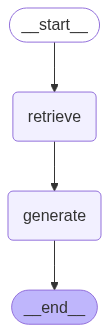

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
result = graph.invoke({"question": "What are the fitness activities covered in the perk plus?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='78c9bc84-4058-433f-a5ba-36f73b85ec74', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf', 'total_pages': 221, 'page': 2, 'page_label': '3', 'start_index': 1487}, page_content="These lessons provide employees with the opportunity to try new things, challenge themselves, and \nimprove their physical skills. They are also a great way to relieve stress and have fun while staying active. \nWith PerksPlus, employees can choose from a variety of fitness programs to suit their individual needs \nand preferences. Whether you're looking to improve your physical fitness, reduce stress, or just have \nsome fun, PerksPlus has you covered. \nWhat is Not Covered? \nIn addition to the wide range of activities covered by PerksPlus, there is also a list of things that are not \ncovered under the program. These include but are not limited to: \n• Non-fitness related e

In [9]:
for step in graph.stream(
    {"question": "What are the fitness activities covered in the perk plus?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='78c9bc84-4058-433f-a5ba-36f73b85ec74', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf', 'total_pages': 221, 'page': 2, 'page_label': '3', 'start_index': 1487}, page_content="These lessons provide employees with the opportunity to try new things, challenge themselves, and \nimprove their physical skills. They are also a great way to relieve stress and have fun while staying active. \nWith PerksPlus, employees can choose from a variety of fitness programs to suit their individual needs \nand preferences. Whether you're looking to improve your physical fitness, reduce stress, or just have \nsome fun, PerksPlus has you covered. \nWhat is Not Covered? \nIn addition to the wide range of activities covered by PerksPlus, there is also a list of things that are not \ncovered under the program. These include but are not limited to: \n• Non-f

In [10]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [11]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[2].metadata

{'producer': 'PyPDF2',
 'creator': 'PyPDF',
 'creationdate': '',
 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf',
 'total_pages': 221,
 'page': 2,
 'page_label': '3',
 'start_index': 0,
 'section': 'beginning'}

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

vectorstore = InMemoryVectorStore(embedding_model)
_ = vectorstore.add_documents(all_splits)

In [13]:
from typing import Literal

from typing_extensions import Annotated

class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [14]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vectorstore.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

In [ ]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

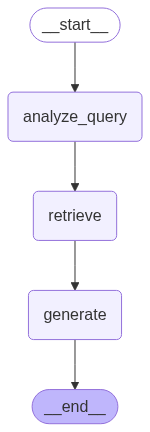

In [15]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
question = str(input("Enter your question: "))

for step in graph.stream(
    {"question": question},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Northwind Standard plan covered services', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='8c8453b7-f424-4b04-b8bf-39d68356dd3e', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf', 'total_pages': 221, 'page': 48, 'page_label': '49', 'start_index': 0, 'section': 'beginning'}, page_content='By following these tips, you can make sure that you are taking advantage of all the benefits \nof the Northwind Standard plan. With the right plan in place, you can be sure that you are \ngetting the best coverage for your medical, dental, vision, and prescription drug needs. \nPreventive Care \nCOVERED SERVICES: Preventive Care \nAt Northwind Health, preventive care services are covered under the Northwind Standard \nplan. Preventive care services are a great way to stay on top of your health, and they are \navai